In [1]:
import networkx as nx 
from matplotlib import pyplot as plt
import numpy as np
import networkx as nx
import torch

from gsnn.models.GSNN import GSNN
from gsnn.simulate.nx2pyg import nx2pyg
from gsnn.simulate.simulate import simulate, simulate_sde

from gsnn.interpret.extract_entity_function import extract_entity_function

%load_ext autoreload
%autoreload 2

# for reproducibility 
torch.manual_seed(0)
np.random.seed(0)

/home/teddy/miniconda3/envs/gsnn-mds/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


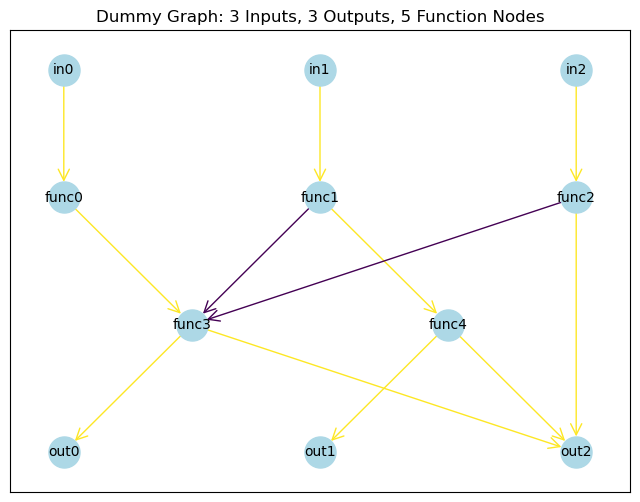

In [2]:
# Create a simple directed graph with 3 inputs, 3 outputs, and 5 function nodes
G = nx.DiGraph()

# Add input nodes, function nodes, and output nodes
input_nodes = ['in0', 'in1', 'in2']
function_nodes = ['func0', 'func1', 'func2', 'func3', 'func4']
output_nodes = ['out0', 'out1', 'out2']

# Add edges from input nodes to function nodes
G.add_edges_from([('in0', 'func0', {'weight': 1}), ('in1', 'func1', {'weight': 1}), ('in2', 'func2', {'weight': 1})])

# Add edges between function nodes
G.add_edges_from([('func0', 'func3', {'weight': 1}), ('func1', 'func4', {'weight': 1}), ('func1', 'func3', {'weight': -1}),('func2', 'func3', {'weight': -1}), ('func2', 'out2', {'weight': 1}), ('func4', 'out2', {'weight': 1})])

# Add edges from function nodes to output nodes
G.add_edges_from([('func3', 'out0', {'weight': 1}), ('func4', 'out1', {'weight': 1}), ('func3', 'out2', {'weight': 1})])

# Define positions for each node for plotting
pos = {
    'in0': (-2, 2), 'in1': (0, 2), 'in2': (2, 2),
    'func0': (-2, 1), 'func1': (0, 1), 'func2': (2, 1),
    'func3': (-1, 0), 'func4': (1, 0),
    'out0': (-2, -1), 'out1': (0, -1), 'out2': (2, -1)
}

edge_sign_dict = {(u,v): G[u][v]['weight'] for u,v in G.edges()}
edge_signs = [G[u][v]['weight'] for u, v in G.edges()]

# Plot the graph
plt.figure(figsize=(8, 6))
nx.draw_networkx(G, pos, with_labels=True, node_color='lightblue', node_size=500, font_size=10, arrowstyle='->', arrowsize=20, edge_color=edge_signs)
plt.title("Dummy Graph: 3 Inputs, 3 Outputs, 5 Function Nodes")
plt.show()

In [3]:

x_train, x_test, y_train, y_test = simulate(G, n_train=100, n_test=1000, input_nodes=input_nodes, output_nodes=output_nodes, 
                                             noise_scale=1., signed_edges=edge_sign_dict)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

x_train = torch.tensor(x_train, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).to(device)

x_test = torch.tensor(x_test, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test, dtype=torch.float32).to(device)

# zscore 
y_mu = y_train.mean(dim=0)
y_std = y_train.std(dim=0)

y_train = (y_train - y_mu) / y_std
y_test = (y_test - y_mu) / y_std

In [4]:
n_epochs= 500

In [5]:
kwargs = {'share_layers': False, 
          'add_function_self_edges': False, 
          'checkpoint': False, 
          'norm': 'layer', 
          'init': 'degree_normalized', 
          'residual': True, 
          'dropout': 0., 
          'channels': 5, 
          'layers': 4}

n params 11800


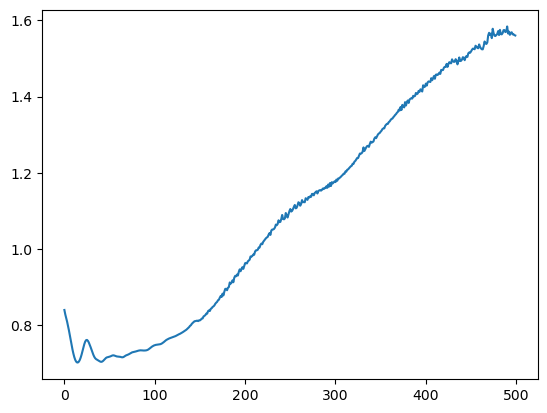

In [7]:
data = nx2pyg(G, input_nodes, function_nodes, output_nodes, weight_attr='weight')

model = GSNN(data.edge_index_dict,
             data.node_names_dict, 
             edge_weight_dict=data.edge_weight_dict,
             node_attn=True,
             **kwargs).to(device)

print('n params', sum([p.numel() for p in model.parameters()]))

optim = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-2)
crit = torch.nn.MSELoss()

losses_gsnn = []
for i in range(n_epochs): 
    model.train()
    optim.zero_grad() 

    yhat = model(x_train)
    loss = crit(y_train, yhat)
    loss.backward() 
    optim.step()

    with torch.no_grad(): 
        model.eval()
        yhat = model(x_test)
        loss = crit(y_test, yhat)
        losses_gsnn.append(loss.item())

    print(f'iter: {i} | loss: {loss.item():.3f}',end='\r')

plt.figure() 
plt.plot(losses_gsnn)
plt.show()

n params 11800


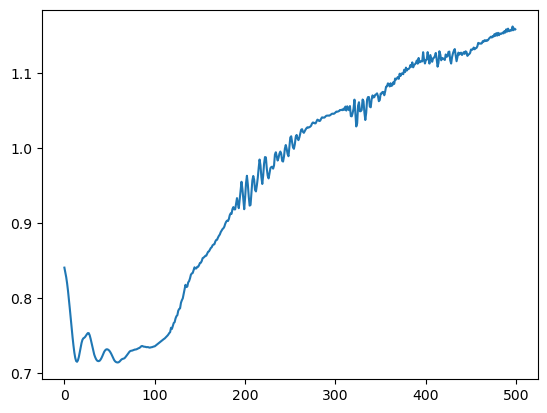

In [ ]:
data = nx2pyg(G, input_nodes, function_nodes, output_nodes, weight_attr='weight')

model = GSNN(data.edge_index_dict,
             data.node_names_dict,
             node_attn=True,
             **kwargs).to(device)

print('n params', sum([p.numel() for p in model.parameters()]))

optim = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-2)
crit = torch.nn.MSELoss()

losses_gsnn = []
for i in range(n_epochs): 
    model.train()
    optim.zero_grad() 

    yhat = model(x_train)
    loss = crit(y_train, yhat)
    loss.backward() 
    optim.step()

    with torch.no_grad(): 
        model.eval()
        yhat = model(x_test)
        loss = crit(y_test, yhat)
        losses_gsnn.append(loss.item())

    print(f'iter: {i} | loss: {loss.item():.3f}',end='\r')

plt.figure() 
plt.plot(losses_gsnn)
plt.show()

In [30]:


def compute_signed_loss(z_dict, edge_sign_dict, device='cpu'): 
    crit = torch.nn.CosineEmbeddingLoss()
    loss = torch.tensor([0.], requires_grad=True, device=device)
    for edge, sign in edge_sign_dict.items():
        src,dst = edge 
        if (src in z_dict) and (dst in z_dict):  
            B = z_dict[src].shape[0] 
            C = z_dict[src].shape[1] 
            zi = z_dict[src]
            zj = z_dict[dst]
            #loss = loss + (torch.bmm(zi.view(B, 1, C), zj.view(B, C, 1)) * sign).sum()
            loss = loss + crit(zi, zj, torch.tensor(B*[sign], device=device))
            loss 
    return loss

 


In [31]:
data = nx2pyg(G, input_nodes, function_nodes, output_nodes)

model = GSNN(data.edge_index_dict,
             data.node_names_dict, 
             **kwargs).to(device)

print('n params', sum([p.numel() for p in model.parameters()]))



n params 8466


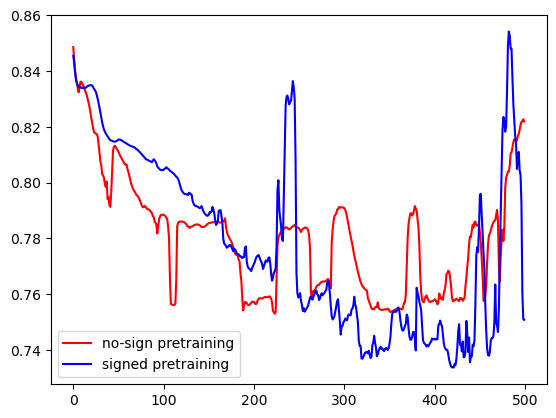

In [32]:

optim = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-2)
crit = torch.nn.MSELoss()

losses_gsnn2 = []
for i in range(n_epochs): 
    model.train()
    optim.zero_grad() 

    yhat = model(x_train)
    loss = crit(y_train, yhat)

    z_dict = model.get_node_activations(x_train) 
    loss2 = compute_signed_loss(z_dict, {key: 1 for key in G.edges()}, device=device)

    loss = loss + loss2*0.1

    loss.backward() 
    optim.step()

    with torch.no_grad(): 
        model.eval()
        yhat = model(x_test)
        loss = crit(y_test, yhat)
        losses_gsnn2.append(loss.item())

    print(f'iter: {i} | loss: {loss.item():.3f}',end='\r')

plt.figure() 
plt.plot(losses_gsnn, 'r-', label='no-sign pretraining')
plt.plot(losses_gsnn2, 'b-', label='signed pretraining')
plt.legend()
plt.show()

In [33]:
data = nx2pyg(G, input_nodes, function_nodes, output_nodes)

model = GSNN(data.edge_index_dict,
             data.node_names_dict, 
             **kwargs).to(device)

print('n params', sum([p.numel() for p in model.parameters()]))



n params 8466


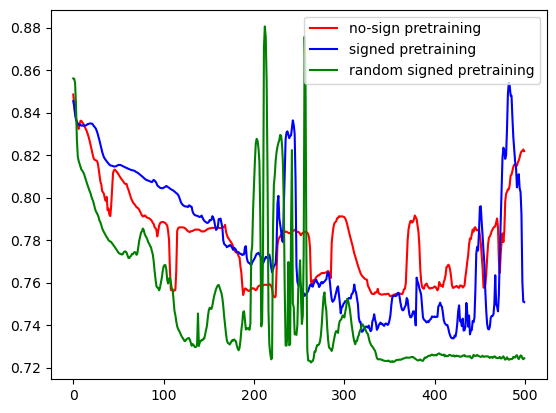

In [34]:
null_sign_dict = {key: np.random.choice([-1,1], p=[0.5,0.5]) for key in G.edges()}

optim = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-2)
crit = torch.nn.MSELoss()

losses_gsnn3 = []
for i in range(n_epochs): 
    model.train()
    optim.zero_grad() 

    yhat = model(x_train)
    loss = crit(y_train, yhat)

    z_dict = model.get_node_activations(x_train) 
    loss2 = compute_signed_loss(z_dict, null_sign_dict, device=device)
    loss = loss + loss2*0.1

    loss.backward() 
    optim.step()

    with torch.no_grad(): 
        model.eval()
        yhat = model(x_test)
        loss = crit(y_test, yhat)
        losses_gsnn3.append(loss.item())

    print(f'iter: {i} | loss: {loss.item():.3f}',end='\r')

plt.figure() 
plt.plot(losses_gsnn, 'r-', label='no-sign pretraining')
plt.plot(losses_gsnn2, 'b-', label='signed pretraining')
plt.plot(losses_gsnn3, 'g-', label='random signed pretraining')
plt.legend()
plt.show()

In [35]:
def compute_signed_loss2(a_dict, edge_sign_dict, device='cpu'): 
    crit = torch.nn.CosineEmbeddingLoss()
    loss = torch.tensor([0.], requires_grad=True, device=device)
    for edge, sign in edge_sign_dict.items():
        src,dst = edge 
        if (src in a_dict) and (dst in a_dict):  
            B = a_dict[src].shape[0] 
            C = a_dict[src].shape[1] 
            ai = a_dict[src]
            aj = a_dict[dst]

            # if sign is 1: if ai is large than aj should be large 
            # if sign is -1: if ai is large than aj should be small 
            dij = torch.clip(sign*(ai - aj), min=0).sum()
            #dij = crit(ai.view(B,1), aj.view(B,1), torch.tensor(B*[sign], device=device, dtype=torch.float32).view(B,1))
            # dij = (sign*ai - aj).sum()
            #dij = torch.mean((sign*ai - aj)**2) - 1e-2*(ai**2).sum()

            loss = loss + dij

    return loss

In [36]:
data = nx2pyg(G, input_nodes, function_nodes, output_nodes)

model = GSNN(data.edge_index_dict,
             data.node_names_dict, 
             **kwargs).to(device)

print('n params', sum([p.numel() for p in model.parameters()]))



n params 8466


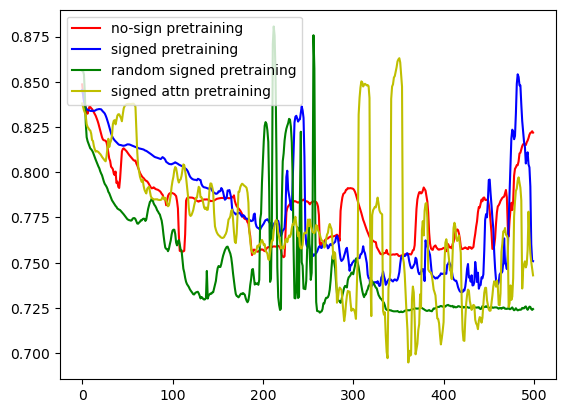

In [37]:

optim = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0)
crit = torch.nn.MSELoss()

losses_gsnn4 = []
for i in range(n_epochs): 
    model.train()
    optim.zero_grad() 

    yhat = model(x_train)
    loss = crit(y_train, yhat)

    a_dict = model.get_node_attention(x_train) 
    loss2 = compute_signed_loss2(a_dict, edge_sign_dict, device=device)
    loss = loss + loss2*0.01
    
    loss.backward() 
    optim.step()

    with torch.no_grad(): 
        model.eval()
        yhat = model(x_test)
        loss = crit(y_test, yhat)
        losses_gsnn4.append(loss.item())

    print(f'iter: {i} | loss: {loss.item():.3f}',end='\r')

plt.figure() 
plt.plot(losses_gsnn, 'r-', label='no-sign pretraining')
plt.plot(losses_gsnn2, 'b-', label='signed pretraining')
plt.plot(losses_gsnn3, 'g-', label='random signed pretraining')
plt.plot(losses_gsnn4, 'y-', label='signed attn pretraining')
plt.legend()
plt.show()

In [38]:
data = nx2pyg(G, input_nodes, function_nodes, output_nodes)

model = GSNN(data.edge_index_dict,
             data.node_names_dict, 
             **kwargs).to(device)

print('n params', sum([p.numel() for p in model.parameters()]))



n params 8466


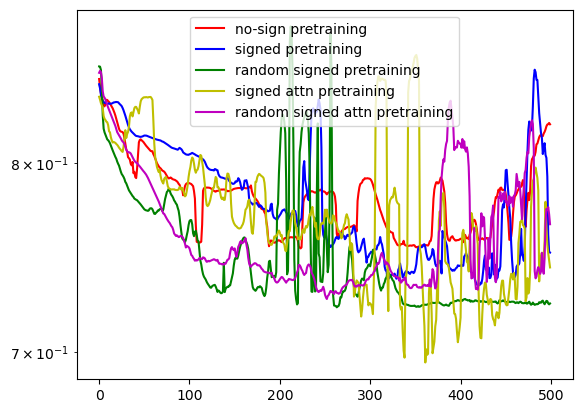

In [39]:

optim = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-2)
crit = torch.nn.MSELoss()

losses_gsnn5 = []
for i in range(n_epochs): 
    model.train()
    optim.zero_grad() 

    yhat = model(x_train)
    loss = crit(y_train, yhat)

    a_dict = model.get_node_attention(x_train) 
    loss2 = compute_signed_loss2(a_dict, null_sign_dict, device=device)
    loss = loss + loss2*0.1
    
    loss.backward() 
    optim.step()

    with torch.no_grad(): 
        model.eval()
        yhat = model(x_test)
        loss = crit(y_test, yhat)
        losses_gsnn5.append(loss.item())

    print(f'iter: {i} | loss: {loss.item():.3f}',end='\r')

plt.figure() 
plt.plot(losses_gsnn, 'r-', label='no-sign pretraining')
plt.plot(losses_gsnn2, 'b-', label='signed pretraining')
plt.plot(losses_gsnn3, 'g-', label='random signed pretraining')
plt.plot(losses_gsnn4, 'y-', label='signed attn pretraining')
plt.plot(losses_gsnn5, 'm-', label='random signed attn pretraining')
plt.legend()
plt.yscale('log')
plt.show()

In [40]:
print('no sign pretraining min test loss', min(losses_gsnn))
print('signed pretraining min test loss', min(losses_gsnn2))
print('random signed pretraining min test loss', min(losses_gsnn3))
print('signed attn pretraining min test loss', min(losses_gsnn4))
print('random signed attn pretraining min test loss', min(losses_gsnn5))

no sign pretraining min test loss 0.753026008605957
signed pretraining min test loss 0.733758807182312
random signed pretraining min test loss 0.7224038243293762
signed attn pretraining min test loss 0.6948591470718384
random signed attn pretraining min test loss 0.7266591191291809
